## Package preparing

In [3]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import random
import math


import datetime as dt
import time

import numbers
from scipy.stats import mvn
from scipy import stats

from sklearn.linear_model import LinearRegression
import empyrical as metrics

import matplotlib.pyplot as plt
plt.rcParams['font.family']=['Heiti TC']
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

np.random.seed(817)
random.seed(817)

## Data read-in

In [ ]:
df=pd.read_csv("xxxx.csv")
df

In [4]:
df = pd.DataFrame(np.random.normal(0,1,[4000,11])+90)
df.columns = ['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','B']


In [5]:
times = pd.to_datetime(pd.date_range('2019-10-1', periods=4000, freq='1h'))
df['times'] = times
hour = times.hour
ind1 = (hour>=9)&(hour<=15)
ind2 = ((hour!=12))
ind = ind1&ind2
df = df.loc[ind,:]
df.reset_index(drop=True,inplace=True)
df['day'] = df['times'].dt.date
df

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,B,times,day
0,89.738626,89.002675,90.301123,89.407802,91.127898,89.540765,90.114104,90.652761,88.817218,90.840481,89.854193,2019-10-01 09:00:00,2019-10-01
1,89.485291,90.515300,90.952322,90.724169,89.907555,90.238340,92.556990,90.057036,90.071029,90.637838,89.536685,2019-10-01 10:00:00,2019-10-01
2,89.950812,90.590627,89.791826,89.428391,90.052897,88.915129,89.597174,90.164777,90.689974,88.987785,89.856296,2019-10-01 11:00:00,2019-10-01
3,90.266456,91.479390,90.977189,88.989774,90.099814,89.379756,89.032778,90.748987,89.774874,88.791192,90.726251,2019-10-01 13:00:00,2019-10-01
4,89.348050,89.875325,90.077675,90.332460,90.299515,88.193700,90.935482,90.413142,89.272187,89.489059,90.391586,2019-10-01 14:00:00,2019-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,92.113566,89.005398,91.745528,89.437198,91.701914,89.825444,90.306704,91.353328,88.411976,89.724442,91.190711,2020-03-15 10:00:00,2020-03-15
998,89.241838,88.071292,88.964062,89.529323,91.344851,91.217592,90.971050,91.767263,89.607834,89.741443,90.834797,2020-03-15 11:00:00,2020-03-15
999,90.418457,91.293253,89.100891,90.759074,90.394182,90.116009,89.385250,88.830473,89.835531,89.947222,88.433624,2020-03-15 13:00:00,2020-03-15
1000,89.097042,90.355123,89.325297,90.447354,90.017317,88.642832,88.545919,90.944310,90.636202,89.712916,91.132925,2020-03-15 14:00:00,2020-03-15


In [6]:
nrow,ncol=df.shape

In [ ]:
## 如果需要自己处理时间向量
#df['time'] = pd.to_datetime(df['time'])
#df ['day'] = pd.to_datetime(df['time']).dt.day
#CL_minutes_return.groupby('day')

#df['hour'] = pd.to_datetime(df['time']).dt.hour

In [5]:
days = pd.unique(df['day'])
day_start = days[20]
day_start

datetime.date(2019, 10, 21)

## APM and Advanced_APM
* 上午
* 下午
* 隔夜

收益率/指数收益率

In [7]:

class return_type(object):
    def __init__(self,stock_name,index_name,onsite_date,lookback,df):
        self.n_stock = len(stock_name)
        self.stock_name = stock_name+index_name
        
        self.onsite_date = onsite_date
        self.lookback = lookback
        self.df = df
        
    
        # past 20 days prices
        self.ind = (self.df['day']<=self.onsite_date)&(self.df['day']>(self.onsite_date-pd.Timedelta(days=self.lookback)))
        self.price_seq = self.df.loc[self.ind,self.stock_name]
        self.time_seq = self.df.loc[self.ind,['times']]
    
    def AM_ret(self):
        # 过去20天上午收益
        open_price = self.price_seq.loc[self.time_seq['times'].dt.hour==9,:]
        open_price.reset_index(drop=True,inplace=True)
        
        close_price = self.price_seq.loc[self.time_seq['times'].dt.hour==11,:]
        close_price.reset_index(drop=True,inplace=True)
        
        res = np.log(close_price/open_price)
        
        return res
    def PM_ret(self):
        # 过去20天下午收益
        open_price = self.price_seq.loc[self.time_seq['times'].dt.hour==13,:]
        open_price.reset_index(drop=True,inplace=True)
        close_price = self.price_seq.loc[self.time_seq['times'].dt.hour==15,:]
        close_price.reset_index(drop=True,inplace=True)
        res = np.log(close_price/open_price)
        
        return res
    
    def ON_ret(self):
        # 过去20天隔夜收益
        ind_ON = (self.df['day']<self.onsite_date)&(self.df['day']>=(self.onsite_date-pd.Timedelta(days=self.lookback)))
        price_seq_ON = self.df.loc[ind_ON,self.stock_name]
        time_seq_ON = self.df.loc[ind_ON,['times']]
        open_price = price_seq_ON.loc[time_seq_ON['times'].dt.hour==15,:]
        open_price.reset_index(drop=True,inplace=True)
        
        close_price = self.price_seq.loc[self.time_seq['times'].dt.hour==9,:]
        close_price.reset_index(drop=True,inplace=True)
        res = np.log(close_price/open_price)
        
        # 过去20天的收益率，代表动量因子
        
        return res
    def Ret20(self):
        open_ind = (self.df['day']==(self.onsite_date-pd.Timedelta(days=self.lookback)))
        open_price = self.df.loc[open_ind,self.stock_name[:(self.n_stock)]]
        open_price = open_price.iloc[-1]
        open_price.reset_index(drop=True,inplace=True)
        
        
        close_ind = (self.df['day']==(self.onsite_date))
        close_price = self.df.loc[close_ind,self.stock_name[:(self.n_stock)]]
        close_price = close_price.iloc[-1]
        close_price.reset_index(drop=True,inplace=True)
        
        res = np.log(close_price/open_price)
        return res
        
    
    def regress(self,adv):
        if adv == 'APM':
            am = self.AM_ret()
        elif adv == 'ADV':
            am = self.ON_ret()
        else:
            print('Please choose from APM and ADV')
        
        pm = self.PM_ret()
        lm_df = pd.concat([am,pm])
        lm_df.reset_index(drop=True,inplace=True)
        lm_model = LinearRegression()
        lm_model.fit(lm_df.iloc[:,-1].values.reshape(-1,1),lm_df.iloc[:,0:self.n_stock].values.reshape(-1,self.n_stock))
        resid = lm_df.iloc[:,0:self.n_stock].values-\
            np.dot(np.ones([2*self.lookback,1]),lm_model.intercept_.reshape(1,-1))-\
            np.dot(lm_df.iloc[:,-1].values.reshape(-1,1),lm_model.coef_.reshape(1,-1))

        delta = (resid[:self.lookback]-resid[self.lookback:])
        delta = (np.mean(delta,axis=0) )/np.std(delta,axis=0)/np.sqrt(self.lookback)
        
        return delta
    
    def apm_factor(self,adv):
        delta = self.regress(adv)
        ret20 = self.Ret20()
        
        apm_model = LinearRegression( fit_intercept=False)
        apm_model.fit(ret20.values.reshape(-1,1),delta.reshape(-1,1))
        
        resid= delta.reshape(-1,1)-apm_model.coef_[0]*ret20.values.reshape(-1,1)
        return resid
    
    def long_short_invest(self,adv,industry=None,capital=None):
        
        apm_values = self.apm_factor(adv)
        
        apm_df = pd.DataFrame(apm_values,columns=['apm'] )
        
        if industry is not None:
            apm_df['industry'] = industry
            apm_df=apm_df.groupby('industry').transform(lambda x:(x-np.mean(x)))
        
        apm_df['stock_name'] = self.df.columns[:self.n_stock].values.tolist()
        k = (self.n_stock)//5 
        
        if capital is not None:
            apm_df['capital'] = capital
            ## sort by capital
            cap_df = apm_df.sort_values('capital')

            
            k_sub = k//5 
            ## k 是总共买入股票个数
            ## k_sub 是每个capital中应该选择的买入股票个数
            ## [k_sub, k_sub,k_sub,k_sub,k-4*k_sub]

            long_set =[]
            short_set = []

            
        else: 
            sort_apm_df=apm_df.sort_values('apm')
            short_set=sort_apm_df['stock_name'].iloc[:k].values.tolist()
            long_set=sort_apm_df['stock_name'].iloc[-k:].values.tolist()
            
        
            
        return apm_df['apm'],long_set,short_set
            
        
    
    def one_step_return(self,adv,next_date,industry=None,capital=None):
        
        apm_values,long_set,short_set= self.long_short_invest(adv,industry,capital)
        
        
        price_past_apm = self.price_seq.loc[self.time_seq['times'].dt.date==self.onsite_date,long_set+short_set]
        price_past_apm = price_past_apm.iloc[-1]


        #price_pre_apm = self.df.loc[df['day']==(self.onsite_date+pd.Timedelta(days=lookahead)),long_set+short_set]
        price_pre_apm = self.df.loc[df['day']==(next_date.date()),long_set+short_set]
        price_pre_apm = price_pre_apm.iloc[-1]

        ## calculate return
        delta_price_apm = price_pre_apm-price_past_apm
        k = (self.n_stock)//5
        cumulate_cash = sum(delta_price_apm.iloc[:k])-sum(delta_price_apm.iloc[k:])
        get_return = cumulate_cash/sum(price_past_apm)
        
        
        ## calculate IC
        
        
        price_past_apm = self.price_seq.loc[self.time_seq['times'].dt.date==self.onsite_date,self.stock_name[:(self.n_stock)]]
        price_past_apm = price_past_apm.iloc[-1]
        


        #price_pre_apm = self.df.loc[df['day']==(self.onsite_date+pd.Timedelta(days=lookahead)),long_set+short_set]
        price_pre_apm = self.df.loc[df['day']==(next_date.date()),self.stock_name[:(self.n_stock)]]
        price_pre_apm = price_pre_apm.iloc[-1]
        
        
        delta_return = (price_pre_apm-price_past_apm)/price_past_apm
        
        IC = stats.spearmanr(delta_return,apm_values)
        
        
        
        return get_return,IC[0]
        
    
        
            
            
        
        
            
        
    

In [8]:

# e.g.
n_stocks = 10
stock_name = df.columns[:n_stocks].values.tolist()
index_name = [df.columns[n_stocks]]
onsite_date = day_start
lookback=20


adv='APM'
return_test = return_type(stock_name,index_name,onsite_date,lookback,df)
apm_test = return_test.apm_factor(adv)
adv='ADV'
adv_apm_test = return_test.apm_factor(adv)

NameError: name 'day_start' is not defined

# 五分组多空对冲

## remove industrial average 

In [9]:
trade_period=[]

days = pd.to_datetime(pd.unique(df['day']))
days = days[20:]

flag=0
while(flag==0):
    
    days_temp = days[:50]
    mm = days[0].month
    if days_temp[-1].month ==mm:
        flag =1
        break
    else:
        trade_date = days_temp[days_temp.month==mm][-1]
    
        
        trade_period.append(trade_date)
        days=days[days>trade_date]
    

trade_period    
   
    
    


[Timestamp('2019-10-31 00:00:00'),
 Timestamp('2019-11-30 00:00:00'),
 Timestamp('2019-12-31 00:00:00'),
 Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-02-29 00:00:00')]

In [10]:
return_seq_apm =[]
return_seq_adv =[]
return_seq_index = []
IC_seq_apm = []
IC_seq_adv = []
lookback=20


for i in range((len(trade_period)-1)):
    trade_date = trade_period[i]
    next_date = trade_period[i+1]
    
    
    
    n_stocks = 10
    stock_name = df.columns[:n_stocks].values.tolist()
    index_name = [df.columns[n_stocks]]
    onsite_date = trade_date
    
    index_price_past = df.loc[df['day']==onsite_date.date(),index_name].iloc[-1].values[0]
    index_price_pre = df.loc[df['day']==next_date.date(),index_name].iloc[-1].values[0]
    
    return_seq_index.append(np.log(index_price_pre/index_price_past))
    


    
    return_test = return_type(stock_name,index_name,onsite_date,lookback,df)
    
    get_return_apm,IC_apm = return_test.one_step_return('APM',next_date,industry=None,capital=None)
    return_seq_apm.append(get_return_apm)
    IC_seq_apm.append(IC_apm)
    
    get_return_adv,IC_adv = return_test.one_step_return('ADV',next_date,industry=None,capital=None)
    return_seq_adv.append(get_return_adv)
    IC_seq_adv.append(IC_adv)
    
return_seq_apm=pd.Series(return_seq_apm)
return_seq_adv = pd.Series(return_seq_adv)
return_seq_index= pd.Series(return_seq_index)
IC_seq_apm=pd.Series(IC_seq_apm)
IC_seq_adv = pd.Series(IC_seq_adv)

In [11]:
## metric dataframe
metric_table = pd.DataFrame(columns = ['APM','ADV'])
metric_table.loc['Annual return',:]=[metrics.annual_return(return_seq_apm,period = 'monthly'),metrics.annual_return(return_seq_adv,period = 'monthly')]
metric_table.loc['Max-Drawdown',:] = [metrics.max_drawdown(return_seq_apm),metrics.max_drawdown(return_seq_adv)]
metric_table.loc['Information ratio',:] = [metrics.sharpe_ratio(return_seq_apm,period = 'monthly'),metrics.sharpe_ratio(return_seq_adv,period = 'monthly')]
metric_table.loc['Monthly Win ratio',:] = [np.mean(return_seq_apm>=0),np.mean(return_seq_adv>=0)]
metric_table.loc['ICIR',:]=[np.mean(IC_seq_apm)/np.std(IC_seq_apm),np.mean(IC_seq_adv)/np.std(IC_seq_adv)]
metric_table

,APM,ADV
Annual return,-0.020825,0.022606
Max-Drawdown,-0.011206,-0.01072
Information ratio,-0.713575,0.726612
Monthly Win ratio,0.25,0.5
ICIR,-0.768221,0.316179


<AxesSubplot:>

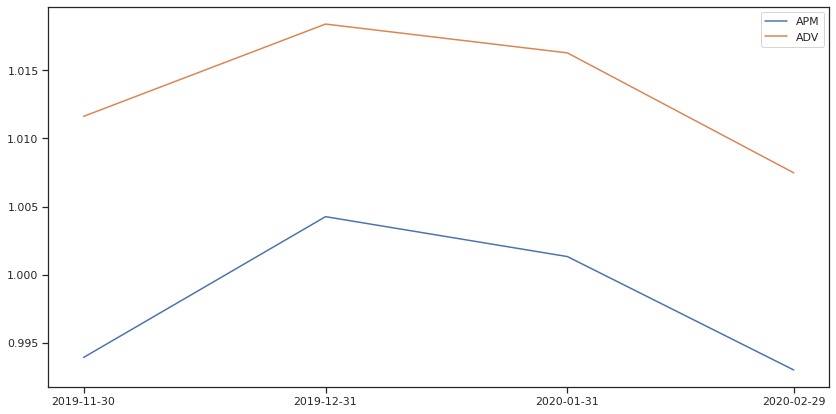

In [13]:
### cumulated cash
## 多空对冲累积收益曲线
cumulated_cash_apm = metrics.cum_returns(return_seq_apm,starting_value=1)
cumulated_cash_adv = metrics.cum_returns(return_seq_adv,starting_value=1)
cumulated_cash = pd.DataFrame(cumulated_cash_apm,columns=['APM'])
cumulated_cash['ADV'] = cumulated_cash_adv
cumulated_cash.index = (pd.to_datetime(trade_period[1:])).date


cumulated_cash.plot(figsize=(14,7),xticks=cumulated_cash.index)

In [58]:
## ICIR（因子值和月末收益的rank coefficient）

np.mean(IC_seq_apm)/np.std(IC_seq_apm),np.mean(IC_seq_adv)/np.std(IC_seq_adv)

(1.7659742406222716, 1.1853302597698814)

## remove capital effect and devide into 5 groups

In [19]:
cap_df = apm_df.sort_values('capital')
cap_df

,apm,adv_apm,stock_name,capital
3,-0.011626,-0.007059,S4,-87.424428
4,-0.011487,0.028371,S5,-23.279243
6,0.032470,0.039029,S7,28.894882
7,0.025475,-0.028659,S8,60.941612
9,-0.002362,0.007347,S10,84.860362
0,-0.019389,-0.018054,S1,183.926978
8,0.029980,-0.064926,S9,216.126391
1,-0.003650,-0.005050,S2,320.221158
2,-0.062450,0.025897,S3,336.598151
5,0.023039,0.023104,S6,452.397196


In [209]:
## e.g.
n=487
k = 487//5
k_sub = k//5
n,k,k_sub,k-4*k_sub

(487, 97, 19, 21)

In [23]:
sort_apm_df=apm_df.sort_values('apm')

short_set=sort_apm_df['stock_name'].iloc[:k].values.tolist()
long_set=sort_apm_df['stock_name'].iloc[-k:].values.tolist()
long_set,short_set

(['S9', 'S7'], ['S3', 'S1'])

In [24]:
# if k_sub>=1

apm_long_set =[]
apm_short_set = []

adv_apm_long_set =[]
adv_apm_short_set = []

for i in range(5):
    start = i*k
    if i<=4:
        end = (i+1)*k
        num = k_sub
    else:
        end = len(cap_df)
        num = k-4*k_sub
    
    
        
    sort_apm_df=cap_df.iloc[start:end,:].sort_values('apm')
    apm_short_set.append(sort_apm_df['stock_name'].iloc[:num].values.tolist())
    apm_long_set.append(sort_apm_df['stock_name'].iloc[-num:].values.tolist())
    
    sort_adv_apm_df=cap_df.iloc[start:end,:].sort_values('adv_apm')
    adv_apm_short_set.append(sort_apm_df['stock_name'].iloc[:num,].values.tolist())
    adv_apm_long_set.append(sort_apm_df['stock_name'].iloc[-num:,].values.tolist())
    
    
    
    


In [26]:
apm_long_set,apm_short_set

([['S4', 'S5'], ['S8', 'S7'], ['S1', 'S10'], ['S2', 'S9'], ['S3', 'S6']],
 [[], [], [], [], []])

In [25]:
adv_apm_long_set,adv_apm_short_set

([['S4', 'S5'], ['S8', 'S7'], ['S1', 'S10'], ['S2', 'S9'], ['S3', 'S6']],
 [[], [], [], [], []])